In [1]:
from cx_model import CXDetector

import numpy as np
import random

np.random.seed(42)
random.seed(42)

import wfdb
from scipy.signal import butter, lfilter, medfilt
from sklearn.preprocessing import RobustScaler

import os

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as patches

/usr/local/lib/python3.6/dist-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
/usr/local/lib/python3.6/dist-packages/numba/errors.py:105: UserWarning: Insufficiently recent colorama version found. Numba requires colorama >= 0.3.9
  warnings.warn(msg)


# Training the model

In [2]:
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

def _read_signal(file, low_freq, high_freq, sample_freq):
    record = wfdb.rdrecord(file)
    annotation = wfdb.rdann(file, 'atr')
    annotated_intervals = list(zip(annotation.sample, annotation.aux_note))
    
    signal_ch1 = record.p_signal[:, 0][1500:-1500]
    signal_ch2 = record.p_signal[:, 2][1500:-1500]
    signal_ch3 = record.p_signal[:, 4][1500:-1500]
    
    signal_ch1 = butter_bandpass_filter(signal_ch1, low_freq, 
                                        high_freq, sample_freq, order=4)
    signal_ch2 = butter_bandpass_filter(signal_ch2, low_freq, 
                                        high_freq, sample_freq, order=4)
    signal_ch3 = butter_bandpass_filter(signal_ch3, low_freq, 
                                        high_freq, sample_freq, order=4)
    
    for i, ann in enumerate(annotated_intervals):
        annotated_intervals[i] = (ann[0] - 1500, ann[1]) 

    signal_ch1 = medfilt(signal_ch1)
    signal_ch2 = medfilt(signal_ch2)
    signal_ch3 = medfilt(signal_ch3)

    ch1_scaler = RobustScaler()
    ch2_scaler = RobustScaler()
    ch3_scaler = RobustScaler()

    signal_ch1 = ch1_scaler.fit_transform(signal_ch1.reshape(-1, 1)).reshape(-1, )
    signal_ch2 = ch2_scaler.fit_transform(signal_ch2.reshape(-1, 1)).reshape(-1, )
    signal_ch3 = ch3_scaler.fit_transform(signal_ch3.reshape(-1, 1)).reshape(-1, )
        
    return signal_ch1, signal_ch2, signal_ch3, annotated_intervals


def _read_clinical(file):
    start_idx = 0
    with open(file+'.hea', 'r') as ifp:
        lines = ifp.readlines()
        
    for line_idx, line in enumerate(lines):
        if line.startswith('#'):
            start_idx = line_idx
            break

    names = []
    values = []
    for line in lines[start_idx+1:]:
        _, name, value = line.split()
        names.append(name)
        values.append(value)

    return names, values

def _process_clinical_df(clin_df):
    clin_df = clin_df.drop(['Gestation'], axis=1)
    clin_df = clin_df.replace('None', np.NaN)
    clin_df = clin_df.replace('N/A', np.NaN)
    clin_df['ID'] = clin_df['RecID']
    for col in ['Rectime', 'Age', 'Abortions', 'Weight']:
        clin_df[col] = clin_df[col].astype(float)
    clin_df = clin_df.drop_duplicates()
    clin_df = clin_df[['file', 'Rectime', 'Age', 'Parity', 'Abortions']]
    return clin_df


def partition_data(directory, n_splits=5):
    files = np.unique([x.split('.')[0] for x in os.listdir(directory)])
    p_files, t_files, n_files = [], [], []
    for file in files:
        if file[-4] == 'n':
            n_files.append(file)
        elif file[-4] == 'p':
            p_files.append(file)
        else:
            t_files.append(file)

    np.random.shuffle(p_files)
    np.random.shuffle(t_files)

    folds = []
    for split in range(n_splits):
        start = lambda x: int(x * (split / n_splits))
        end   = lambda x: int(x * ((split + 1) / n_splits))
        if split == n_splits - 1:
            test_p_files = p_files[start(len(p_files)):]
            test_t_files = t_files[start(len(t_files)):]
        else:
            test_p_files = p_files[start(len(p_files)):end(len(p_files))]
            test_t_files = t_files[start(len(t_files)):end(len(t_files))]

        train_p_files = sorted(list(set(p_files) - set(test_p_files)))
        train_t_files = sorted(list(set(t_files) - set(test_t_files)))

        test_files = test_t_files + test_p_files
        train_files = train_t_files + train_p_files

        folds.append((['{}{}{}'.format(directory, os.sep, x) for x in train_files], 
                      ['{}{}{}'.format(directory, os.sep, x) for x in test_files]))

    return folds

In [3]:
folds = partition_data('tpehgts')
train_files, test_files = folds[0]
detector = CXDetector(20, 0.05, 4.0, 750, 125, 100, 100, _read_signal, _read_clinical, _process_clinical_df)
features = detector.fit(train_files)

Learning rate set to 0.029109
0:	learn: 0.6768448	test: 0.6714530	best: 0.6714530 (0)	total: 159ms	remaining: 26m 27s
100:	learn: 0.1672094	test: 0.1533615	best: 0.1533615 (100)	total: 7.56s	remaining: 12m 21s
200:	learn: 0.0842679	test: 0.1413783	best: 0.1412323 (199)	total: 14.8s	remaining: 12m 1s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.1401971479
bestIteration = 211

Shrink model to first 212 iterations.


In [7]:
list(features.columns)

['boss_aaaa_ch0',
 'boss_aaab_ch0',
 'boss_aaac_ch0',
 'boss_aaad_ch0',
 'boss_aaba_ch0',
 'boss_aabb_ch0',
 'boss_aabc_ch0',
 'boss_aabd_ch0',
 'boss_aaca_ch0',
 'boss_aacb_ch0',
 'boss_aacc_ch0',
 'boss_aacd_ch0',
 'boss_aada_ch0',
 'boss_aadb_ch0',
 'boss_aadc_ch0',
 'boss_aadd_ch0',
 'boss_abaa_ch0',
 'boss_abab_ch0',
 'boss_abac_ch0',
 'boss_abad_ch0',
 'boss_abba_ch0',
 'boss_abbb_ch0',
 'boss_abbc_ch0',
 'boss_abbd_ch0',
 'boss_abca_ch0',
 'boss_abcb_ch0',
 'boss_abcc_ch0',
 'boss_abcd_ch0',
 'boss_abda_ch0',
 'boss_abdb_ch0',
 'boss_abdc_ch0',
 'boss_abdd_ch0',
 'boss_acaa_ch0',
 'boss_acab_ch0',
 'boss_acac_ch0',
 'boss_acad_ch0',
 'boss_acba_ch0',
 'boss_acbb_ch0',
 'boss_acbc_ch0',
 'boss_acbd_ch0',
 'boss_acca_ch0',
 'boss_accb_ch0',
 'boss_accc_ch0',
 'boss_accd_ch0',
 'boss_acda_ch0',
 'boss_acdb_ch0',
 'boss_acdc_ch0',
 'boss_acdd_ch0',
 'boss_adaa_ch0',
 'boss_adab_ch0',
 'boss_adac_ch0',
 'boss_adad_ch0',
 'boss_adba_ch0',
 'boss_adbb_ch0',
 'boss_adbc_ch0',
 'boss_adb

# Evaluating the model

In [4]:
from sklearn.metrics import roc_auc_score

def get_labels_preds(intervals, predictions):
    preds = []
    labels = []
    for (start_idx, start_type), (end_idx, end_type) in zip(intervals[::2], intervals[1::2]):
        if start_idx < 0 or end_idx >= len(predictions):
            continue
        if start_type[-1] == 'C':
            labels.extend([1]*(end_idx - start_idx))
            preds.extend(predictions.loc[list(range(start_idx, end_idx)), 'pred'].values)
        else:
            labels.extend([0]*(end_idx - start_idx))
            preds.extend(predictions.loc[list(range(start_idx, end_idx)), 'pred'].values)

    return labels, preds

def _load_pred_labels_intervals(predictions):
    _, _, _, intervals = _read_signal(predictions['file'].values[0], 0.05, 4.0, 20.0)
    labels, preds = get_labels_preds(intervals, predictions)
    return labels, preds, intervals

def unweighted_auc(predictions):
    all_labels, all_preds = [], []
    for file in np.unique(predictions['file']):
        preds = predictions[predictions['file'] == file].set_index('index', drop=True)
        labels, preds, intervals = _load_pred_labels_intervals(preds)
        all_labels.extend(labels)
        all_preds.extend(preds)

    mask = ~np.isnan(all_preds)
    return roc_auc_score(np.array(all_labels)[mask], np.array(all_preds)[mask])

def create_plots(predictions):
    def create_plot(signal_ch1, signal_ch2, signal_ch3, predictions, intervals):
        f, ax = plt.subplots(4, 1, sharex=True, figsize=(15,3))
        ax[0].plot(signal_ch1)
        ax[1].plot(signal_ch2)
        ax[2].plot(signal_ch3)

        _max = np.max([np.max(signal_ch1), np.max(signal_ch2), np.max(signal_ch3)])
        _min = np.min([np.min(signal_ch1), np.min(signal_ch2), np.min(signal_ch3)])

        for (start_idx, start_type), (end_idx, end_type) in zip(intervals[::2], intervals[1::2]):
            if start_type[-1] == 'C':
                color = 'g'
            elif start_type == '(c)':
                color = 'y'
            else:
                color = 'r'

            for k in range(3):
                rect = patches.Rectangle((start_idx, _min), end_idx - start_idx, _max - _min, facecolor=color, alpha=0.5)
                ax[k].add_patch(rect)

        ax[3].plot(predictions)
        plt.show()
        plt.close()
        
    for file in np.unique(predictions['file']):
        sign_ch1, sign_ch2, sign_ch3, intervals = _read_signal(file, 0.05, 4.0, 20.0)
        create_plot(sign_ch1, sign_ch2, sign_ch3, predictions[predictions['file'] == file]['pred'].values, intervals)

0.7999423327805162


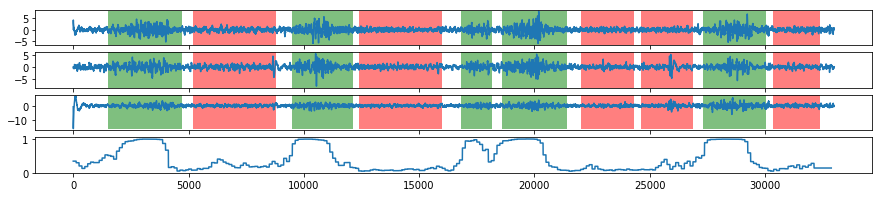

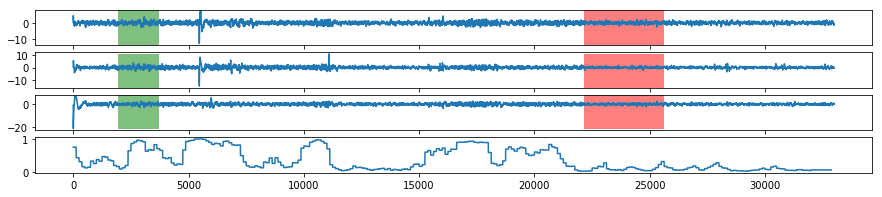

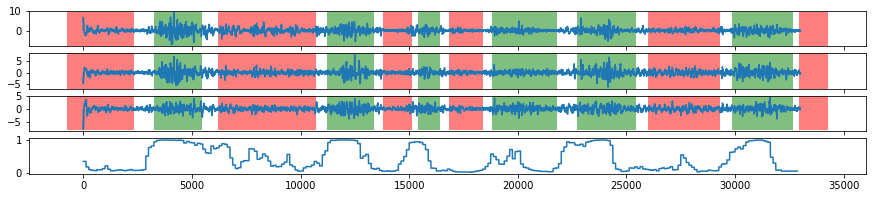

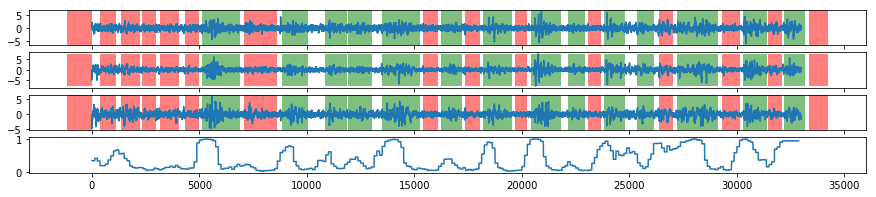

In [5]:
preds = detector.predict(test_files)
print(unweighted_auc(preds))
create_plots(preds) #0.7999423327805162